# 一、数据生成器
## 1、自建数据生成器
自建数据生成器仅支持二分类，建议使用API数据生成器

In [1]:
import glob

# real_list  = glob.glob(r".\images\1/*.png")
# glitch_list = glob.glob(r".\images\0/*png")

real_list  = glob.glob(r".\Hotdog\train\hotdog/*.png")  
glitch_list = glob.glob(r".\Hotdog\train\not-hotdog/*png")

list_img = real_list+glitch_list

print(len(real_list), len(glitch_list))

1000 1000


In [2]:
import cv2
import numpy as np
import pprint as pp

def get_batch(img_list, label_list, batch_size=8, show=False):
    # 在方法中需要用while写成死循环，因为每个step不会重新调用方法
    while True:
        index = np.random.choice(range(len(img_list)), batch_size)
        batch_list = [img_list[i] for i in index]
        batch_row = [cv2.imread(img) for img in batch_list]
        batch_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in batch_row]
        batch_matrix = [cv2.resize(i,(224, 224),interpolation=cv2.INTER_CUBIC) for i in batch_gray]
        batch_label = [label_list[i] for i in index]
        if show:
            pp.pprint(list(zip(batch_list, batch_label)))
        batch_matrix = np.concatenate(np.expand_dims(batch_matrix, axis=0), axis=0).astype(float)
        batch_label = np.array(batch_label)
        # batch_matrix = np.expand_dims(batch_matrix, -1)
        batch_matrix = (batch_matrix).astype(int)/255.
        yield batch_matrix, batch_label  # , batch_list


list_lab = np.zeros([len(list_img), 2], dtype=int)
list_lab[:len(real_list), 0] = 1  # real: [1, 0]
list_lab[len(real_list):, 1] = 1  # fake: [0, 1]
b = next(get_batch(list_img, list_lab, show=True))

[('.\\Hotdog\\train\\not-hotdog\\259.png', array([0, 1])),
 ('.\\Hotdog\\train\\not-hotdog\\914.png', array([0, 1])),
 ('.\\Hotdog\\train\\not-hotdog\\859.png', array([0, 1])),
 ('.\\Hotdog\\train\\not-hotdog\\598.png', array([0, 1])),
 ('.\\Hotdog\\train\\hotdog\\61.png', array([1, 0])),
 ('.\\Hotdog\\train\\not-hotdog\\82.png', array([0, 1])),
 ('.\\Hotdog\\train\\hotdog\\694.png', array([1, 0])),
 ('.\\Hotdog\\train\\hotdog\\890.png', array([1, 0]))]


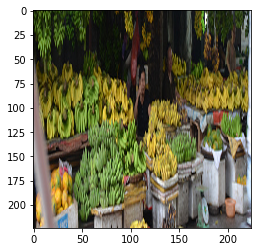

In [3]:
import matplotlib.pyplot as plt
num = np.random.randint(0, len(b))
img = (b[0][num]*255).astype(np.uint8) 
plt.imshow(img)
plt.show()
# print(b[2][num])
# pp.pprint(list(zip(b[1][:], b[2][:])))

## 2、API数据生成器
官方的数据读取器，路径指定到图片父级目录，其下有各个class的子目录即可

In [1]:
from keras.preprocessing.image import ImageDataGenerator

# train_datagen=ImageDataGenerator(rescale=1./255)
# train_flow=train_pic_gen.flow_from_directory(r'./hotdog\train',target_size=(128, 128),batch_size=32,class_mode='categorical')

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_flow = train_datagen.flow_from_directory(
        r'.\猫狗数据',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')

C:\software\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 25000 images belonging to 2 classes.


# 二、网络定义

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten,Dropout 
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import InceptionV3


# model = Sequential()
# model.add(Conv2D(32, 3, 3, input_shape=(224, 224, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
 
# model.add(Conv2D(32, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
 
# model.add(Conv2D(64, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())# this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2))
# model.add(Activation('sigmoid'))

model = Sequential()
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.add(inception)
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='sigmoid'))
 
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
# top_model.load_weights(top_model_weights_path)
# add the model on top of the convolutional base
model.add(top_model)
for layer in inception.layers[:]:
    layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 13107970  
Total params: 34,910,754
Trainable params: 13,107,970
Non-trainable params: 21,802,784
_________________________________________________________________


# 三、训练

In [ ]:
from keras import losses
import keras.backend as K
from keras import optimizers
from keras.callbacks import TensorBoard

samples_per_epoch = 10000  # len(list_img)
batch_size = 32

# K.set_value(sgd.lr, 0.5 * K.get_value(sgd.lr))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit_generator(train_flow,  
                    # get_batch(list_img, list_lab),
                    steps_per_epoch=5*samples_per_epoch//batch_size, # samples_per_epoch//batch_size, 
                    epochs=5,
                    shuffle=True,
                    callbacks=[TensorBoard(log_dir='./tmp/log', write_graph=True)])
# model.fit(img, label, batch_size=8, epochs=10)
model.save('model.h5')

Epoch 1/5


# 四、测试
须将下面两个路径替换为测试图片的路径：
```
test_real_list  = glob.glob("./0/*.jpg")
test_glitch_list = glob.glob("./1/*jpg")
```

In [ ]:
import matplotlib.pyplot as plt

test_real_list  = glob.glob("./0/*.jpg")
test_glitch_list = glob.glob("./1/*jpg")
test_list_img = test_real_list + test_glitch_list

img_test = [cv2.imread(i) for i in test_list_img]
img_test = [cv2.resize(i,(300, 300),interpolation=cv2.INTER_CUBIC)
            for i in img_test]
img_test = np.concatenate(np.expand_dims(img_test, axis=0), axis=0)/255

label_test = np.zeros([len(img_test), 2], dtype=int)
label_test[:len(test_real_list), 0] = 1
label_test[len(test_real_list):, 1] = 1
pp.pprint(list(zip(test_list_img, label_test)))

In [9]:
import keras.models as KM

model = KM.load_model('model.h5')
result = model.evaluate(img_test, label_test)
pp.pprint(list(zip(model.metrics_names, result)))

42/42 [==============================] - 1s 13ms/step
[('loss', 0.009871753686595531), ('acc', 1.0)]
